# **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# **Load the Dataset**

In [2]:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# **Preprocess Dataset**

## **Split Data into Features (X) and Labels (y)**

In [3]:
X = data.v2
X.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: v2, dtype: object

In [4]:
y = data.v1
y.head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: v1, dtype: object

In [5]:
X.shape, y.shape

((5572,), (5572,))

## **Convert labels into categorical variables**

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

y[:5]

array([0, 0, 1, 0, 0])

## **Tokenize and Pad input features**

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, oov_token="<oov>")

tokenizer.fit_on_texts(X)

In [8]:
word_dict = tokenizer.word_index
len(word_dict)

8921

In [9]:
inverse_word_dict = tokenizer.index_word
len(inverse_word_dict)

8921

In [10]:
X = tokenizer.texts_to_sequences(X)
X[:5]

[[51,
  470,
  4411,
  842,
  752,
  658,
  65,
  9,
  1325,
  90,
  122,
  350,
  1326,
  148,
  2988,
  1327,
  68,
  59,
  4412,
  145],
 [47, 337, 1496, 471, 7, 1930],
 [48,
  487,
  9,
  20,
  5,
  797,
  900,
  3,
  179,
  1931,
  1200,
  659,
  1932,
  2321,
  268,
  2322,
  72,
  1931,
  3,
  1933,
  3,
  338,
  487,
  555,
  956,
  74,
  389,
  180,
  660,
  390,
  2989],
 [7, 246, 153, 24, 380, 2990, 7, 141, 155, 58, 153],
 [1019, 2, 99, 108, 70, 488, 3, 957, 70, 1934, 219, 112, 472]]

In [11]:
max_words = max([len(i) for i in X])
max_words

189

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_words, padding='post', truncating='post')
X.shape

(5572, 189)

## **Split the data into Training and Test Sets**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
X_train.shape, y_train.shape

((4457, 189), (4457,))

In [15]:
X_test.shape, y_test.shape

((1115, 189), (1115,))

# **Create the Model**

In [16]:
model = tf.keras.models.Sequential()

2022-10-25 10:52:11.569596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 10:52:11.684639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 10:52:11.685413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 10:52:11.686545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **Add Layers to the Model**

In [17]:
model.add(tf.keras.layers.Input((max_words,)))
model.add(tf.keras.layers.Embedding(max_words+1, 512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(32, return_sequences=False))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 512)          97280     
_________________________________________________________________
batch_normalization (BatchNo (None, 189, 512)          2048      
_________________________________________________________________
lstm (LSTM)                  (None, 189, 128)          328192    
_________________________________________________________________
dropout (Dropout)            (None, 189, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 64)           49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 189, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                1

# **Compile the Model**

In [18]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

# **Fit the Model**

In [19]:
hist = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2, validation_batch_size=32, shuffle=True)

Epoch 1/25


2022-10-25 10:52:15.079286: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-25 10:52:19.682863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 9s 60ms/step - loss: 0.5207 - accuracy: 0.8693 - val_loss: 0.4408 - val_accuracy: 0.8632
Epoch 2/25
56/56 [==============================] - 2s 39ms/step - loss: 0.4059 - accuracy: 0.8704 - val_loss: 0.4154 - val_accuracy: 0.8632
Epoch 3/25
56/56 [==============================] - 2s 39ms/step - loss: 0.4056 - accuracy: 0.8704 - val_loss: 0.4225 - val_accuracy: 0.8632
Epoch 4/25
56/56 [==============================] - 2s 39ms/step - loss: 0.4030 - accuracy: 0.8704 - val_loss: 0.4341 - val_accuracy: 0.8632
Epoch 5/25
56/56 [==============================] - 2s 40ms/step - loss: 0.3990 - accuracy: 0.8704 - val_loss: 0.4260 - val_accuracy: 0.8632
Epoch 6/25
56/56 [==============================] - 2s 39ms/step - loss: 0.3965 - accuracy: 0.8704 - val_loss: 0.4237 - val_accuracy: 0.8632
Epoch 7/25
56/56 [==============================] - 2s 39ms/step - loss: 0.3988 - accuracy: 0.8704 - val_loss: 0.4168 - val_accuracy: 0.8632
Epoch 8/25
56/56 [======

# **Save the Model**

In [20]:
model.save("spam_classification.h5")

# **Visualize Model Outputs**

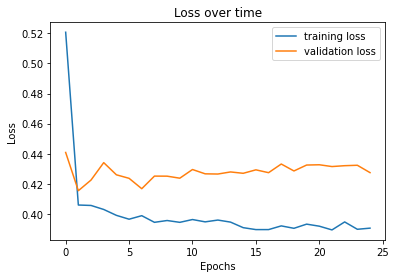

In [21]:
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.title("Loss over time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

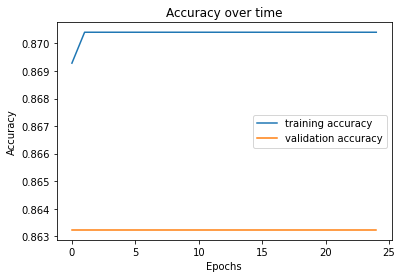

In [22]:
plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.title("Accuracy over time")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# **Test the Model**

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test Loss : {test_loss:0.2f}")
print(f"Test Accuracy : {test_acc*100:0.2f} %")

35/35 [==============================] - 0s 11ms/step - loss: 0.4386 - accuracy: 0.8538
Test Loss : 0.44
Test Accuracy : 85.38 %
